<a href="https://colab.research.google.com/github/HanbomWoo/-Dentis-_malocclusion/blob/master/prototype_model_regression_prediction_hyg__solip_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prototype Model
---

* Regression
* 2009 data로 class1,2,3 10fold


https://docs.google.com/presentation/d/1cI3teBcQoGBhfrdVrv9rnM4jHGaPToDS7Zh7t0q7GKg/edit#slide=id.g97e66187c6_0_6

In [ ]:
import tensorflow as tf

In [ ]:
from random import seed as random_seed
random_seed(50)
from numpy.random import seed as np_random_seed
np_random_seed(50)

tf.random.set_seed(50)

In [ ]:
import os

os.sys.path.append(r'/docker_mnt/data5/jin/jin/python/')

os.sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/docker_mnt/data5/jin/jin/python/']

In [ ]:
import tensorflow as tf
tf.__version__
from tensorflow.python.client import device_lib
device_lib.list_local_devices()


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9847743609149323591]

In [ ]:
%env PYTHONHASHSEED=0
from random import seed as random_seed
random_seed(42)
from numpy.random import seed as np_random_seed
np_random_seed(42)

import glob
import os
import pprint
from tqdm import tqdm

from IPython import display
import ipywidgets as widgets

# Data Science
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('seaborn-white')
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')

import cv2 as cv

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import models, layers, activations, initializers, regularizers, optimizers, losses, callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

env: PYTHONHASHSEED=0


## Paths
---

In [ ]:
so_type = 'so_rl'

input_path_root = r'../../data/input_data/' # input data 경로 지정

# <model 저장>
output_path_root = r'../../results/fixed/' # output 결과 경로 지정
# output_path_root = r'../results/hyg/'
output_path = os.path.join(output_path_root, r'prototype_regression_so_img/', so_type) # output 경로에 prototype_regression_so_img 파일도 함께 불러오기.
output_path_weight = os.path.join(output_path, r'weights/') 

try:
    os.makedirs(output_path_weight)
except FileExistsError as err: 
    print(err)
# else:
#     print(output_path)
#     print(output_path_weight)

In [ ]:
input_path_root

'../../data/input_data/'

In [ ]:
output_path

'../../results/fixed/prototype_regression_so_img/so_rl'

## Data
---
- Class 0 : 분별하기 어려운 data (65 sample) -> 제외

- Class 3 : 하악이 상악보다 앞으로 돌출된 경우 (1136 sample) -> -1.0
- Class 1 : 상하악의 맞물림 상태는 정상이지만 치열이 고르지 않은 경우 (1707 sample) -> 0.0
- Class 2 : 상악이 하악보다 앞으로 돌출된 경우 (1175 sample) -> 1.0


In [ ]:
def convert_label_class2reg(label_df):
    label_r = np.copy(label_df.angle_class_r)
    label_df.loc[label_r == 1, 'angle_class_r'] = 0   # 행과 열에 접근하여 우측 class값에 클래스 넘버 배열. (.loc method이용)
    label_df.loc[label_r == 2, 'angle_class_r'] = 1   # angle_class(분류기준)가 열에 해당 
    label_df.loc[label_r == 3, 'angle_class_r'] = -1
    
    label_l = np.copy(label_df.angle_class_l)
    label_df.loc[label_l == 1, 'angle_class_l'] = 0   # 행과 열에 접근하여 좌측 class값에 클래스 넘버 배열.
    label_df.loc[label_l == 2, 'angle_class_l'] = 1
    label_df.loc[label_l == 3, 'angle_class_l'] = -1
    
    return label_df

def generate_data_by_patient(x, y): # ***def patient(x,y) 에서 x,y 값이 무엇인지
    if x.shape[-1] == 12: # 이미지가 4개(사용x)
        x = np.concatenate([x[..., :3], x[..., 3:6], x[..., 6:9], x[..., 9:]]) 
        y = np.concatenate([y[:, 0], y[:, 1], y[:, 2], y[:, 3]])
    elif x.shape[-1] == 6: # 이미지가 2개(좌,우) * 3차원 = 6
        x = np.concatenate([x[..., :3], x[..., 3:]]) # 
        y = np.concatenate([y[:, 0], y[:, 1]])
    
    return x, y

# def generate_info_df_by_patient(info_df):
#     info_df_r = info_df.copy()
#     for row_idx, info in enumerate(info_df_r['info']):
#         info_df_r.iloc[row_idx] = info + '_r'
        
#     info_df_l = info_df.copy()
#     for row_idx, info in enumerate(info_df_l['info']):
#         info_df_l.iloc[row_idx] = info + '_l'
    
#     info_df = pd.concat((info_df_r, info_df_l), ignore_index=True)
#     del info_df_r, info_df_l
    
#     info_df1 = info_df.copy()
        
#     info_df2 = info_df.copy()
#     for row_idx, info in enumerate(info_df2['info']):
#         info_df2.iloc[row_idx] = info.replace('01A1', '02B1')
    
#     info_df = pd.concat((info_df1, info_df2), ignore_index=True)
#     del info_df1, info_df2

#     return info_df

In [ ]:
x = np.load(os.path.join(input_path_root, f'data_KNU_Diorco_so_imgs.npy')) # input 경로에서부터 data_KNU_Diorco_so_imgs.npy로 새경로 생성
label_df = pd.read_csv(os.path.join(input_path_root, f'data_Diorco_label.csv')) # input 경로에서부터 data_Diorco_label.csv로 새경로 생성 후 csv 파일 불러오기
label_df = convert_label_class2reg(label_df) # label_df를 convert_label_class2reg에서 할당한 0 -1 1에 대한 label data frame 생성

y = label_df.loc[:, ['angle_class_r', 'angle_class_l']].to_numpy() # 

x = x.astype(np.float32) # x,y의 data type을 float형으로 바꾸기
                         
y = y.astype(np.float32)

x = x / 127.5 
x = x - 1

#x = np.concatenate((x[::2, ...], x[1::2, ...]), axis=3)
#y = np.concatenate((y[::2, ...], y[1::2, ...]), axis=1)

- read_csv() 함수를 사용해서 외부 text 파일, csv 파일을 불러와서 DataFrame으로 저장.

- os.path.join('C:\Tmp', 'a', 'b') -> "C:\Tmp\a\b"경로를 병합하여 새 경로 생성

- 2차원 자료구조인 DataFrame는 행과 열이 있는 테이블 데이타(Tabular Data)를 받아들인다.


1.  Data Type 객체(dtype)

- 앞서 만들었던 객체에 대한 각 데이터 타입을 설정할 수 있는 명령어가 있고, 이 부분을 통해서 각 배열에 데이터 타입을 지정할 수 있습니다.
- numpy.dtype(object, align, copy)
-object : data type객체를 통해 변경될 부분

- copy : data type객체를 복사하여 새로운 객체 생성

- ex) 획득한 데이터의 Shape은 [4, 3, 32, 32]입니다.

- Shape 정보로부터 현재 획득한 데이터는 4차원의 구조를 가지며, 4개 이미지가  각각 3개의 채널을 가집니다. 그리고 이미지 크기는 32X32. (요소개수 따라 shape차원 결정)

2. concatenate () :
- print(np.concatenate((a, b), axis=0))
- 두 Numpy 배열을 다양한 shape로 합친 결과입니다.
- axis 값을 조절하여 어떤 축을 기준으로 배열을 합칠지 정할 수 있다.





In [ ]:
print(x.dtype, x.shape) # x와 y의 data type과 shape 출력
print(y.dtype, y.shape) 
print()
display.display(label_df.info()) 
display.display(label_df)

plt.style.use('seaborn-whitegrid')
plt.figure()

plt.title('Label')
sns.countplot(np.concatenate([label_df.angle_class_r, label_df.angle_class_l])) # sns.countplot; 차트 세로로 그리기
                                                                                # label_df.angle_class_l이란 -1 0 1 기준에 대한 data frame에서의 r과l의 배열을 합침.
plt.show()
plt.style.use('seaborn-white')

In [ ]:
cnt = np.concatenate([label_df.angle_class_r, label_df.angle_class_l]) # r과l을 묶어서 총 4018개의 data 있음
cnt.shape

In [ ]:
len(cnt[cnt==-1]) 

In [ ]:
len(cnt[cnt==0])

In [ ]:
len(cnt[cnt==1])

In [ ]:
len(cnt[cnt==-1]) + len(cnt[cnt==0]) + len(cnt[cnt==1])

## Model
---

In [ ]:
def build_model():
    base_model = InceptionResNetV2(include_top=False, weights=None, input_shape=(None, None, 3))
    # model로 InceptionResNetV2 사용, input_shape는 클래스 범주에 맞게 3개로 분류)

    x = base_model.output

    x = layers.GlobalAveragePooling2D(name='gap')(x)
    x = layers.Dense(256, activation='relu', name='dense')(x) # 256개 노드로 구성된 은닉층
    x = layers.Dropout(0.2, name='dropout')(x) # 20%의 입력값(노드)을 0으로 만들어줌
    output_main = layers.Dense(1, name='output_main')(x)

    model = models.Model(inputs=base_model.input, outputs=output_main) 
  
    
    return model

1. **'Inception-ResNet-v2'**:

- ImageNet 데이터베이스의 1백만 개가 넘는 영상에 대해 훈련된 convolution신경망
- 이 신경망에는 164개의 계층이 있으며, 영상을 키보드, 마우스, 연필, 각종 동물 등 1,000가지 사물 범주로 분류가능.
- InceptionResNetV2(네트워크 상단에 완전히 연결된 layer를 포함할지 여부, 가중치-로드할 가중치 파일에 대한 경로 중 하나, input data의 shape 결정)
 

2. **ReLU**
- 내부 hidden layer를 활성화 시키는 함수로 sigmoid를 사용하지 않고 ReLU라는 활성화 함수를 사용하게 되는데, 이 함수는 쉽게 말해 0보다 작은 값이 나온 경우 0을 반환, 0보다 큰 값이 나온 경우 그 값 그대로 반환. (0보다 큰 값일 경우 1을 반환하는 sigmoid와 다르다). 따라서 내부 hidden layer에는 ReLU를 적용하고, 마지막 output layer에서만 sigmoid 함수를 적용하면 정확도가 훨씬 올라가게 됨.

3. **Pooling의 역할**
- CNN에는 많은 convolution layer를 쌓기 때문에 필터의 수가 많음.
- 파라미터가 너무 많아지면 학습 시 over fitting이 발생할 수 있는 문제 발생.
- 이런 역할을 CNN에서 해주는 레이어를 pooling layer라고 함.
- 따라서 필터에 사용된 파라미터 수를 줄여서 차원을 감소시킬 방법이 필요.

4. **'*layers*.Dense'**
- input을 넣었을 때 output으로 바꿔주는 중간 다리
- layers.Dense(출력값 크기, 활성화함수,등등)

5. '**layers.dropout**'
- overfitting 방지 목적
- 모델에 Dropout 함수를 적용할 경우, 과적합을 방지하기 위해 무작위로 특정 노드(입력값)를 0으로 만든다.

6. **교차검증**
- 과적합을 막기위함
- 훈련 data set를 바꿔가며 훈련하면서 나온 평균은 정확도로 보는 방법을 말함.

(1).k-fold:   k만큼의 fole 세트에 k번의 학습과 검증을한다. 이러한 방법으로 k번 평가한다.
- 한번의 학습을 통해 평가할 경우 과적합 가능성 크다. 
- 일정한 간격으로 잘라서 사용하기 때문에 학습이 안되는 답은 도출하지 못한다는 문제가 생길 수 있다.

(2). StratifiedKFold:
- target에 속성값의 개수를 동일하게 가져감으로써 kfold 같이 데이터가 한곳으로 몰리는 것을 방지.

7. **Compile**

- 모델을 학습시키기 이전에, 메소드를 통해서 학습 방식에 대한 환경설정을 해야 합니다. 다음의 세 개의 인자가 입력으로 받음.

- (최적화): 나 와 같은 기존의 정규화기에 대한 문자열 식별자 또는 클래스의 인스턴스를 사용할 수 있습니다. 주: 적기rmsprp, adagrad, Optimizer

- 손실 함수(손실 기능). 모델이 최적화에 사용되는 목적 함수입니다. 또는 와 같은 기존의 손실 함수의 문자열 식별자 또는 목적 함수를 사용할 수 있습니다. 주: categorical_crossentropy, mse

- (미터법) 리미터. 분류 문제에 대해서는 설정합니다. 기준은 문자열 식별자 또는 사용자 정의 기준 함수를 사용할 수 있습니다. metrics=['accuracy']

8. Adam

- 각 parameter마다 다른 크기의 업데이트를 적용하는 방법

9. mae
- 이 모델은 mse 손실 함수를 사용하여 컴파일합니다. 이 함수는 평균 제곱 오차(mean squared error)의 약어로 예측과 타깃 사이 거리의 제곱입니다. 회귀 문제에서 널리 사용되는 손실 함수이다.

- 훈련하는 동안 모니터링을 위해 새로운 지표인 평균 절대 오차(Mean Absolute Error, MAE)를 측정합니다. 

- 이는 예측과 타깃 사이 거리의 절댓값입니다.
 
- 예를 들어 이 예제에서 MAE가 0.5면 예측이 평균적으로 500달러 정도 차이가 난다는 뜻입니다.

10. random_state = 42

- train_test_split()는 데이터를 무작위로 섞은 뒤, 데이터 셋을 나눈다. 그래서 함수를 호출할 때마다 다른 결과로 분할이 된다.
- random_state를 특정 숫자로 지정하면 항상 동일하게 분할할 수 있다. 실제 상황에서는 거의 필요 없지만, 실험결과를 똑같이 재현해야 할 때는 유용하게 쓰인다.



## Train the Model
---

In [ ]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # 10폴드로 무작위로 데이터 셋을 나눈다
for kfold_idx, (train_idxs, test_idxs) in enumerate(kfold.split(x, y[:, 0])):
    if kfold_idx==0: # 
        display.clear_output(wait=True)
        print(f'K-Fold CV: {kfold_idx + 1:02d}/{kfold.n_splits:02d}')
        
        x_train = x[train_idxs]
        y_train = y[train_idxs]
        label_df_train = label_df.iloc[train_idxs]

        x_train, x_val, y_train, y_val, label_df_train, label_df_val = train_test_split(x_train, y_train, label_df_train, test_size=0.2, 
                                                                                        random_state=42, stratify=y_train[:, 0]) 
        # test set을 20%, train_set을 80%로 하는 무작위 배열의 train_set setting.

        x_test = x[test_idxs]
        y_test = y[test_idxs]
        label_df_test = label_df.iloc[test_idxs]

        x_train, y_train = generate_data_by_patient(x_train, y_train)
        x_val, y_val = generate_data_by_patient(x_val, y_val)
        x_test, y_test = generate_data_by_patient(x_test, y_test)
        
        output_path_kfold = os.path.join(output_path, f'kfold_{kfold_idx + 1:02d}/')
        output_path_weight = os.path.join(output_path_kfold, r'weights/')
        
        if os.path.isdir(output_path_weight)==False:
            os.makedirs(output_path_weight)
            
        if kfold_idx == 0:
            model = build_model()

            model.compile(optimizer=optimizers.Adam(lr=1e-3),
                          loss=losses.MeanSquaredError(),
                          metrics=['mae','acc'])

            model.save(os.path.join(output_path, r'model.hdf5'))

        # model.summary()
        else:
            model = models.load_model(os.path.join(output_path, r'model.hdf5'))
        
        checkpointer = callbacks.ModelCheckpoint(os.path.join(output_path_weight, 'weights_{epoch:08d}_{val_loss:.4g}.hdf5'),
                                                 save_weights_only=True)
        csv_logger = callbacks.CSVLogger(os.path.join(output_path_kfold, r'log.csv'), append=True)
        
        # Training batch size 16 -> 8
        model.fit(x_train, y_train,
                  batch_size=8,
                  epochs=50,
                  validation_data=(x_val, y_val),
                  callbacks=[checkpointer, csv_logger],
                  initial_epoch=1,
                  verbose=1)

        K.clear_session()
        del model

## Evaluation
---

In [ ]:
info_df = label_df.copy()
info_df

,patient_id,tx_phase,angle_class_r,angle_class_l,distance(r),distance(l)
0,QH0026,Pre-Tx,0,0,1.48,1.23
1,QH0026,Post-Tx,0,1,1.22,2.10
2,QH0041,Pre-Tx,1,0,2.57,0.88
3,QH0041,Post-Tx,1,0,3.58,1.05
4,QH0044,Pre-Tx,1,1,6.94,4.63
...,...,...,...,...,...,...
2004,QH1058,Post-Tx,0,0,2.00,1.00
2005,QH1072,Pre-Tx,-1,-1,-4.99,-2.83
2006,QH1072,Post-Tx,1,1,7.41,5.26
2007,QH1084,Pre-Tx,0,-1,-0.55,-0.55


In [ ]:
info_df.iloc[[0,3,5,6,7]]

,patient_id,tx_phase,angle_class_r,angle_class_l,distance(r),distance(l)
0,QH0026,Pre-Tx,0,0,1.48,1.23
3,QH0041,Post-Tx,1,0,3.58,1.05
5,QH0044,Post-Tx,1,1,9.15,7.06
6,QH0059,Pre-Tx,0,0,1.13,0.81
7,QH0059,Post-Tx,1,-1,1.53,0.49


In [ ]:
output_path

'../results/prototype_regression_so_img/so_rl/'

In [ ]:
output_path_kfold

'../../results/fixed/prototype_rg_prediction/so_rl/kfold_01/'

In [ ]:
output_path_weight

'../results/prototype_regression_so_img/so_rl/kfold_01/weights/'

K-Fold CV: 01/10


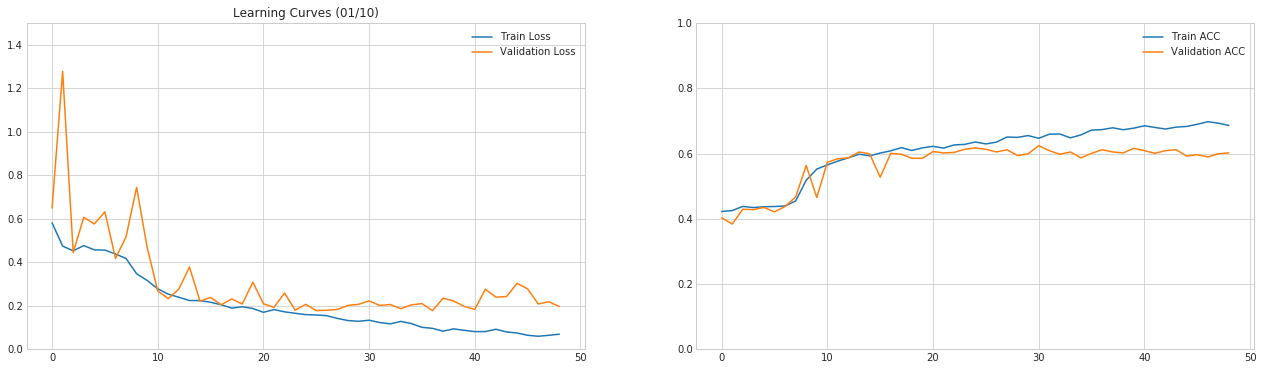

Min. validation loss epoch: 26
Min. validation MAE epoch: 40
Max. validation MAE epoch: 31
K-Fold CV: 02/10
K-Fold CV: 03/10
K-Fold CV: 04/10
K-Fold CV: 05/10
K-Fold CV: 06/10
K-Fold CV: 07/10
K-Fold CV: 08/10
K-Fold CV: 09/10
K-Fold CV: 10/10


In [ ]:
metrics = []
predictions_kfold = []
labels_kfold = []
distance_regression = [] 

total_info =[]
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for kfold_idx, (train_idxs, test_idxs) in enumerate(kfold.split(x, y[:, 0])):
    print(f'K-Fold CV: {kfold_idx + 1:02d}/{kfold.n_splits:02d}')
    
    if kfold_idx==0:
        
        # 1. Data
        # ----------------------------------------

        x_test = x[test_idxs]
        y_test = y[test_idxs]

        label_df_test = label_df.iloc[test_idxs]

        x_test, y_test = generate_data_by_patient(x_test, y_test)

        # 2. Paths
        # ----------------------------------------

        output_path_kfold = os.path.join(output_path, f'kfold_{kfold_idx + 1:02d}/')
        output_path_weight = os.path.join(output_path_kfold, r'weights/')

        # 3. Plot Learning Curves.
        # ----------------------------------------

        # log 저장: loss, mae, val_loss, val_mae
        log_df = pd.read_csv(os.path.join(output_path_kfold, r'log.csv'))


        plt.style.use('seaborn-whitegrid')
        plt.figure(figsize=( 22, 6 ))

        plt.subplot(121)
        plt.title(f'Learning Curves ({kfold_idx + 1:02d}/{kfold.n_splits:02d})')
        plt.plot(log_df.loss)
        plt.plot(log_df.val_loss)
        plt.ylim(0, 1.5)
        plt.legend(('Train Loss', 'Validation Loss'))

#         plt.subplot(122)
#         plt.plot(log_df.mae)
#         plt.plot(log_df.val_mae)
#         plt.ylim(0, 1.5)
#         plt.legend(('Train MAE', 'Validation MAE'))

        plt.subplot(122)
        plt.plot(log_df.acc)
        plt.plot(log_df.val_acc)
        plt.ylim(0, 1)
        plt.legend(('Train ACC', 'Validation ACC'))
        
        plt.show()
        plt.style.use('seaborn-white')
        print(f'Min. validation loss epoch: {log_df.val_loss.idxmin() + 1}')
        print(f'Min. validation MAE epoch: {log_df.val_mae.idxmin() + 1}')
        print(f'Max. validation MAE epoch: {log_df.val_acc.idxmax() + 1}')



        info_df = label_df.copy()

        result_info_df = info_df.iloc[test_idxs]

        inference_df = result_info_df.copy()

        # 4. Load a Model.
        # ----------------------------------------

        K.clear_session()

        #sgcwhb/Malocclusion/results/prototype_regression_so_img/so_rl/model.hdf5
        model = models.load_model(os.path.join(output_path, r'model.hdf5'))
        #validation mae가 가장 적은 model weight load
        model.load_weights(glob.glob(os.path.join(output_path_weight, f'weights_{log_df.val_mae.idxmin() + 1:08d}*.hdf5'))[0])

        # 5. Display
        # ----------------------------------------


        prediction = model.predict(x_test)

        prediction_distance_r = prediction[:int(prediction.shape[0]/2),0] #Right
        prediction_distance_l = prediction[int(prediction.shape[0]/2):,0] #left

        r = prediction_distance_r.copy()
        l = prediction_distance_l.copy()

        #-1~1사이 score
        r = np.round(r) #반올림
        r[r<-1]= -1
        r[r>1] = 1

        l = np.round(l)
        l[l<-1]= -1
        l[l>1] = 1    

    #     print(l.shape)
    #     print(r.shape)
    #     print(info_df.shape)
    #     print(result_info_df.shape)

        inference_df['prediction_class_r'] = r
        inference_df['prediction_class_l'] =l
        inference_df['regression_distance_r'] = np.round(prediction_distance_r,3)
        inference_df['regression_distance_l'] = np.round(prediction_distance_l,3)


        inference_df.to_csv(os.path.join(output_path_kfold, r'info.csv'))
        total_info.append(inference_df)

    total_df = pd.concat(total_info)
    total_df.to_csv('../results/prototype_regression_so_img/so_rl/total.csv')


In [ ]:
log_df.val_acc.max()

0.6243094

In [ ]:
total_df=pd.read_csv('../results/prototype_regression_so_img/so_rl/total.csv')

In [ ]:
total_df

,Unnamed: 0,patient_id,tx_phase,angle_class_r,angle_class_l,distance(r),distance(l),prediction_class_r,prediction_class_l,regression_distance_r,regression_distance_l
0,4,QH0044,Pre-Tx,1,1,6.94,4.63,1.0,1.0,0.954,0.929
1,6,QH0059,Pre-Tx,0,0,1.13,0.81,0.0,-0.0,0.001,-0.003
2,28,QH0126,Pre-Tx,1,1,3.07,1.82,1.0,1.0,0.808,0.780
3,31,QH0129,Post-Tx,0,-1,0.44,0.88,0.0,-0.0,0.000,-0.003
4,33,QH0145,Post-Tx,-1,-1,-1.54,-1.93,-1.0,-1.0,-0.887,-0.580
...,...,...,...,...,...,...,...,...,...,...,...
196,1961,QH0542,Post-Tx,1,1,6.60,4.91,1.0,1.0,0.839,0.818
197,1980,QH0854,Pre-Tx,1,1,1.88,3.69,1.0,1.0,0.895,0.911
198,1998,QH1024,Post-Tx,0,1,1.05,7.29,1.0,1.0,0.876,0.890
199,2000,QH1037,Post-Tx,0,0,0.57,0.45,0.0,1.0,0.240,0.764


In [ ]:
data = total_df['angle_class_r'].append(total_df['angle_class_l'])
prediction =  total_df['prediction_class_r'].append(total_df['prediction_class_l'])
data = np.array(data)
prediction=np.array(prediction,dtype = int)


cm = confusion_matrix(data, prediction, labels=[-1, 0, 1])

print(cm)
print("")
print(f'Accuracy: {(cm[0, 0] + cm[1, 1] + cm[2, 2]) / cm.sum():.3f}')

[[ 86  13   4]
 [ 23 141  12]
 [  2  27  94]]

Accuracy: 0.799


In [ ]:
np.sum(cm)

4018

![image.png](attachment:image.png)